In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as MSE

from sklearn.linear_model import ElasticNetCV
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

from tensorflow.keras.metrics import mean_squared_error as tfMSE
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import Model, Input
from tensorflow.keras import metrics, regularizers, callbacks

In [2]:
test = pd.read_csv('/content/drive/MyDrive/fantasy_football/test_2021.csv').sample(frac=1)
train = pd.read_csv('/content/drive/MyDrive/fantasy_football/train_2010-2020.csv').sample(frac=1)
print(train.shape)
train.head()

(4935, 13)


,Rk,Player,Age,G,GS,PPR,VBD,FantPos_Other,FantPos_QB,FantPos_RB,FantPos_TE,FantPos_WR,NextRk
4027,92,Andy Dalton,32,13,13,203.7,0.0,0,1,0,0,0,96.0
1767,12,Jamaal Charles,28,15,15,250.4,89.0,0,0,1,0,0,155.0
1660,402,Cyrus Gray,24,16,0,14.0,0.0,0,0,1,0,0,401.0
4393,579,Josh Malone,23,2,0,0.0,0.0,1,0,0,0,0,502.0
883,576,Armond Smith,25,3,0,0.2,0.0,0,0,1,0,0,572.0


In [3]:
X_train = train.drop(columns=['Player', 'NextRk'])
Y_train = train.NextRk

X_test = test.drop(columns=['Player', 'NextRk'])
Y_test = test.NextRk

In [4]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Elastic Net Regression

In [5]:
elnet = ElasticNetCV(l1_ratio=0.5, cv=5)
elnet.fit(X_train_scaled, Y_train)
Y_pred = elnet.predict(X_test_scaled)
test['ENetPred'] = np.round(Y_pred)

In [6]:
elnet_mse = MSE(Y_test, Y_pred)
elnet_mse

15892.986073199498

# Support Vector Regression

In [7]:
svm_reg = svm.SVR()
svm_reg.fit(X_train_scaled, Y_train)
Y_pred = svm_reg.predict(X_test_scaled)
test['SVRPred'] = np.round(Y_pred)

In [8]:
svm_mse = MSE(Y_test, Y_pred)
svm_mse

19890.05393313216

# K-Nearest Neighbors Regression

100it [00:15,  6.64it/s]


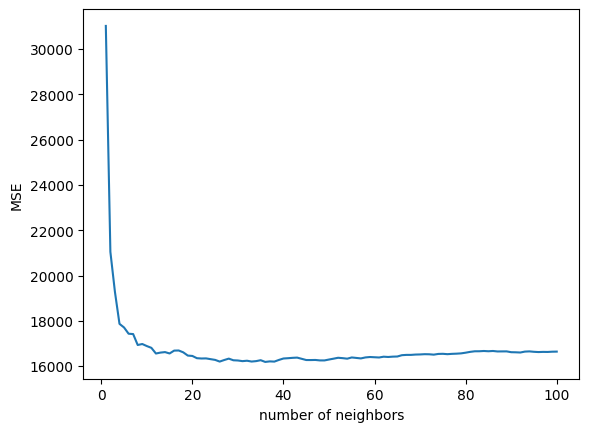

In [9]:
ks = np.arange(1,101)
k_mse = np.zeros(len(ks))
for i,k in tqdm(enumerate(ks)):
  knn = KNeighborsRegressor(n_neighbors=k)
  knn.fit(X_train_scaled, Y_train)
  Y_pred = knn.predict(X_test_scaled)
  k_mse[i] = MSE(Y_test, Y_pred)

plt.plot(ks, k_mse)
plt.xlabel('number of neighbors')
plt.ylabel('MSE');

In [10]:
k = ks[k_mse.argmin()]
knn = KNeighborsRegressor(n_neighbors=k)
knn.fit(X_train_scaled, Y_train)
Y_pred = knn.predict(X_test_scaled)
test['KNNPred'] = np.round(Y_pred)

In [11]:
knn_mse = MSE(Y_test, Y_pred)
knn_mse

16183.52817205096

# Gradient Boosting Regression

10it [00:22,  2.29s/it]


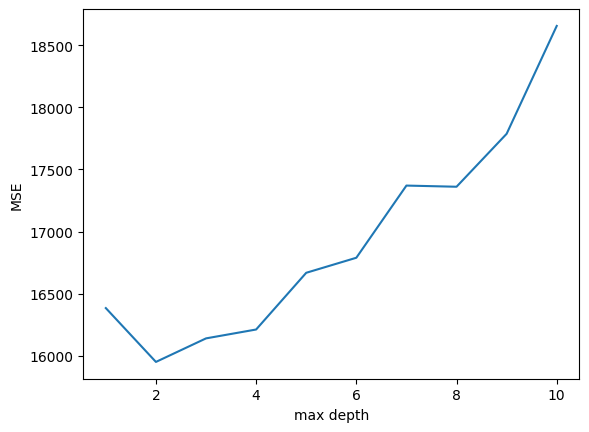

In [12]:
depths = np.arange(1,11)
depth_mse = np.zeros(len(depths))
for i,depth in tqdm(enumerate(depths)):
  gbr = GradientBoostingRegressor(max_depth=depth)
  gbr.fit(X_train_scaled, Y_train)
  Y_pred = gbr.predict(X_test_scaled)
  depth_mse[i] = MSE(Y_test, Y_pred)

plt.plot(depths, depth_mse)
plt.xlabel('max depth')
plt.ylabel('MSE');

7it [00:10,  1.48s/it]


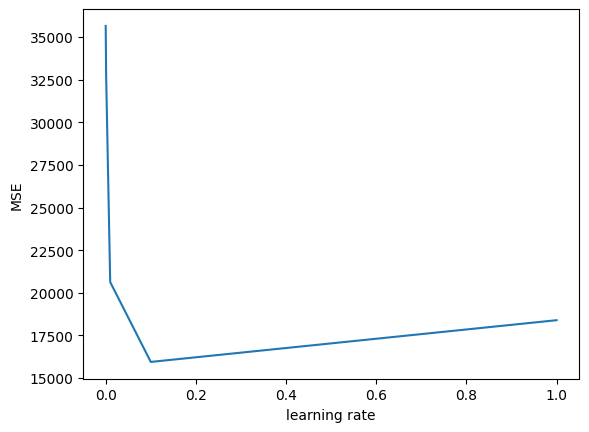

In [13]:
max_depth = depths[depth_mse.argmin()]

rates = np.array([10**float(x) for x in np.arange(-6,1)])
rate_mse = np.zeros(len(rates))
for i,rate in tqdm(enumerate(rates)):
  gbr = GradientBoostingRegressor(max_depth=max_depth, learning_rate=rate)
  gbr.fit(X_train_scaled, Y_train)
  Y_pred = gbr.predict(X_test_scaled)
  rate_mse[i] = MSE(Y_test, Y_pred)

plt.plot(rates, rate_mse)
plt.xlabel('learning rate')
plt.ylabel('MSE');

In [14]:
rate = rates[rate_mse.argmin()]

gbr = GradientBoostingRegressor(max_depth=max_depth, learning_rate=rate)
gbr.fit(X_train_scaled, Y_train)
Y_pred = gbr.predict(X_test_scaled)
test['GBRPred'] = np.round(Y_pred)

In [15]:
gbr_mse = MSE(Y_test, Y_pred)
gbr_mse

15950.068449918177

In [16]:
gbr.feature_importances_.round(4)

array([5.357e-01, 1.820e-02, 1.960e-02, 6.900e-03, 4.008e-01, 3.700e-03,
       1.320e-02, 8.000e-04, 1.000e-03, 2.000e-04, 0.000e+00])

# Deep Neural Network

In [17]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.ylim(15_000,20_000)
  plt.legend()
  plt.grid(True)

### Model 1

In [18]:
inputs = Input(shape=(11,))
x = Dense(8, activation='relu')(inputs)
x = Dense(8, activation='relu')(x)
outputs = Dense(1)(x)

model1 = Model(inputs=inputs, outputs=outputs, name='model')
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 11)]              0         
                                                                 
 dense (Dense)               (None, 8)                 96        
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 177
Trainable params: 177
Non-trainable params: 0
_________________________________________________________________


In [19]:
%%time
model1.compile(optimizer='adam', loss='mean_squared_error')
history1 = model1.fit(X_train_scaled, Y_train,
                    batch_size=32, epochs=200,
                    validation_data=(X_test_scaled, Y_test),
                    verbose=0)

CPU times: user 53.9 s, sys: 2.49 s, total: 56.4 s
Wall time: 54.6 s


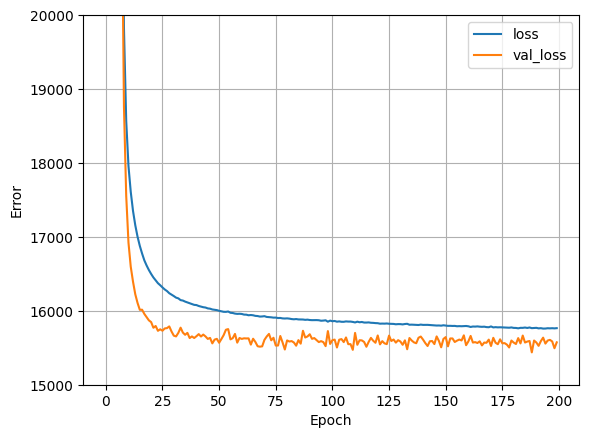

In [20]:
plot_loss(history1)

In [21]:
Y_pred = model1.predict(X_test_scaled)
test['DNN1Pred'] = np.round(Y_pred)
dnn1_mse = MSE(Y_test, Y_pred)
dnn1_mse

16/16 [==============================] - 0s 1ms/step


15573.079159209701

### Model 2

In [22]:
inputs = Input(shape=(11,))
x = Dense(8, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(16, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(16, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(8, activation='relu')(x)
outputs = Dense(1)(x)

model2 = Model(inputs=inputs, outputs=outputs, name='model')
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 11)]              0         
                                                                 
 dense_4 (Dense)             (None, 16)                192       
                                                                 
 batch_normalization_1 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 16)                272       
                                                                 
 batch_normalization_2 (Batc  (None, 16)               64        
 hNormalization)                                             

In [ ]:
%%time
model2.compile(optimizer='adam', loss='mean_squared_error')
history2 = model2.fit(X_train_scaled, Y_train,
                    batch_size=32, epochs=400,
                    validation_data=(X_test_scaled, Y_test),
                    verbose=0)

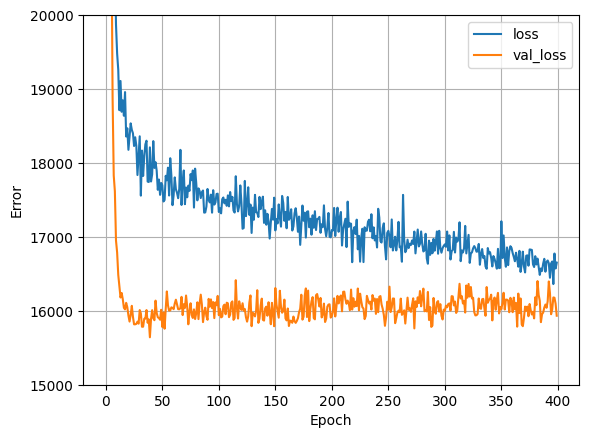

In [40]:
plot_loss(history2)

In [41]:
Y_pred = model2.predict(X_test_scaled)
test['DNN2Pred'] = np.round(Y_pred)
dnn2_mse = MSE(Y_test, Y_pred)
dnn2_mse

16/16 [==============================] - 0s 4ms/step


15933.415944279535

### Model 3

In [43]:
inputs = Input(shape=(11,))
x = Dense(8, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(8, activation='relu')(x)
outputs = Dense(1)(x)

model3 = Model(inputs=inputs, outputs=outputs, name='model')
model3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 11)]              0         
                                                                 
 dense_23 (Dense)            (None, 256)               3072      
                                                                 
 batch_normalization_10 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_24 (Dense)            (None, 256)               65792     
                                                                 
 batch_normalization_11 (Bat  (None, 256)              1024      
 chNormalization)                                            

In [29]:
%%time
model3.compile(optimizer='adam', loss='mean_squared_error')
history3 = model3.fit(X_train_scaled, Y_train,
                    batch_size=32, epochs=400,
                    validation_data=(X_test_scaled, Y_test),
                    verbose=0)

CPU times: user 4min 51s, sys: 12.7 s, total: 5min 4s
Wall time: 5min 26s


(13000.0, 20000.0)

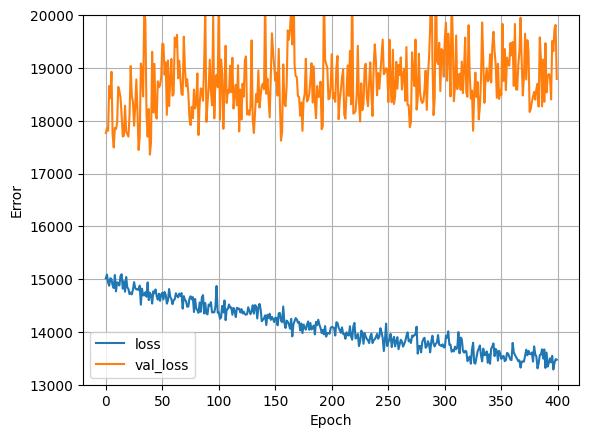

In [30]:
plot_loss(history3)
plt.ylim(13000, 20000)

In [31]:
Y_pred = model3.predict(X_test_scaled)
test['DNN3Pred'] = np.round(Y_pred)
dnn3_mse = MSE(Y_test, Y_pred)
dnn3_mse

16/16 [==============================] - 0s 2ms/step


18791.21525003974

### Model 4

In [32]:
inputs = Input(shape=(11,))
x = Dense(8, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(8, activation='relu')(x)
outputs = Dense(1)(x)

model4 = Model(inputs=inputs, outputs=outputs, name='model')
model4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 11)]              0         
                                                                 
 dense_14 (Dense)            (None, 32)                384       
                                                                 
 batch_normalization_7 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_15 (Dense)            (None, 8)                 264       
                                                                 
 dense_16 (Dense)            (None, 1)                 9         
                                                             

In [33]:
%%time
model4.compile(optimizer='adam', loss='mean_squared_error')
history4 = model4.fit(X_train_scaled, Y_train,
                    batch_size=32, epochs=600,
                    validation_data=(X_test_scaled, Y_test),
                    verbose=0)

CPU times: user 3min 12s, sys: 7.78 s, total: 3min 20s
Wall time: 3min 23s


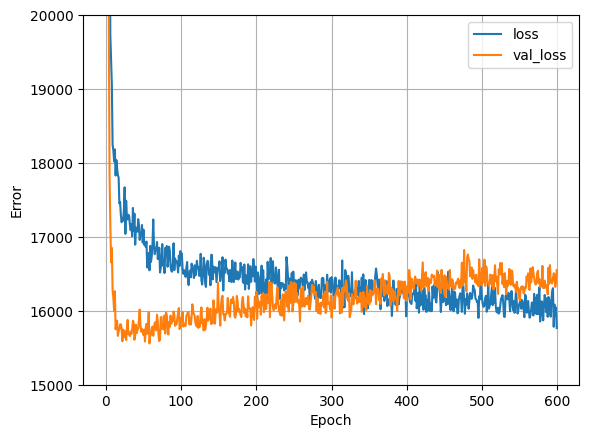

In [34]:
plot_loss(history4)


In [35]:
Y_pred = model4.predict(X_test_scaled)
test['DNN4Pred'] = np.round(Y_pred)
dnn4_mse = MSE(Y_test, Y_pred)
dnn4_mse

16/16 [==============================] - 0s 2ms/step


16549.98449198075

### Model 5

In [36]:
inputs = Input(shape=(11,))
x = Dense(16, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(16, activation='relu')(x)
outputs = Dense(1)(x)

model5 = Model(inputs=inputs, outputs=outputs, name='model')
model5.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 11)]              0         
                                                                 
 dense_17 (Dense)            (None, 16)                192       
                                                                 
 batch_normalization_8 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 16)                0         
                                                                 
 dense_18 (Dense)            (None, 16)                272       
                                                                 
 dense_19 (Dense)            (None, 1)                 17        
                                                             

In [37]:
%%time
model5.compile(optimizer='adam', loss='mean_squared_error')
history5 = model5.fit(X_train_scaled, Y_train,
                    batch_size=32, epochs=600,
                    validation_data=(X_test_scaled, Y_test),
                    verbose=0)

CPU times: user 3min 7s, sys: 7.71 s, total: 3min 15s
Wall time: 2min 51s


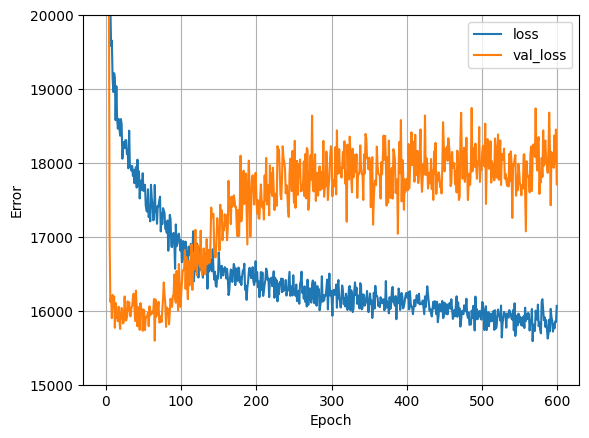

In [38]:
plot_loss(history5)

In [39]:
Y_pred = model5.predict(X_test_scaled)
test['DNN5Pred'] = np.round(Y_pred)
dnn5_mse = MSE(Y_test, Y_pred)
dnn5_mse

16/16 [==============================] - 0s 2ms/step


17710.814410074854

### Model 6

In [42]:
inputs = Input(shape=(11,))
x = Dense(64, activation='relu')(inputs)
outputs = Dense(1)(x)

model6 = Model(inputs=inputs, outputs=outputs, name='model')
model6.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 11)]              0         
                                                                 
 dense_20 (Dense)            (None, 64)                768       
                                                                 
 dense_21 (Dense)            (None, 1)                 65        
                                                                 
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


In [47]:
%%time
model6.compile(optimizer='adam', loss='mean_squared_error')
history6 = model6.fit(X_train_scaled, Y_train,
                    batch_size=32, epochs=250,
                    validation_data=(X_test_scaled, Y_test),
                    verbose=0)

CPU times: user 1min 4s, sys: 3.14 s, total: 1min 7s
Wall time: 1min 25s


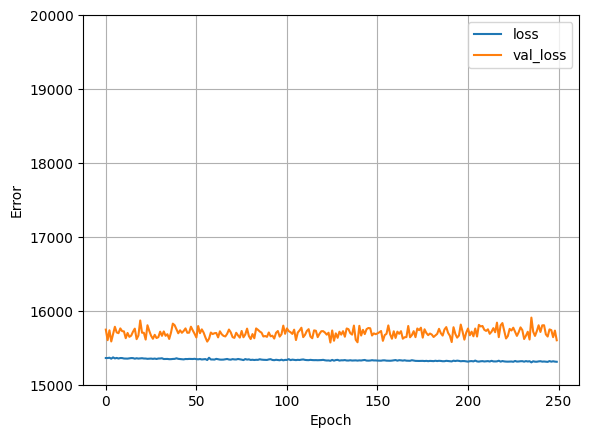

In [48]:
plot_loss(history6)

In [49]:
Y_pred = model6.predict(X_test_scaled)
test['DNN6Pred'] = np.round(Y_pred)
dnn6_mse = MSE(Y_test, Y_pred)
dnn6_mse

16/16 [==============================] - 0s 1ms/step


15601.554598480556

# Make Predictions for 2023

In [75]:
all_ranks = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vSwnO49IGl-uGORj7NZYYnuKMWEQK6RcKi1gcTqmGnu8i7gb_SYPvPy-gAyu6h7tt10SXDTqCWbm0eB/pub?gid=0&single=true&output=csv')
all_ranks.shape

(563, 2)

In [77]:
pred = pd.read_csv('/content/drive/MyDrive/fantasy_football/predict_2022.csv')
pred.head()

,Rk,Player,Age,G,GS,PPR,VBD,FantPos_Other,FantPos_QB,FantPos_RB,FantPos_TE,FantPos_WR
0,1,Patrick Mahomes,27,17,17,417.4,136.0,0,1,0,0,0
1,2,Josh Jacobs,24,17,17,328.3,127.0,0,0,1,0,0
2,3,Christian McCaffrey,26,17,16,356.4,123.0,0,0,1,0,0
3,4,Derrick Henry,28,16,16,302.8,122.0,0,0,1,0,0
4,5,Justin Jefferson,23,17,17,368.7,119.0,0,0,0,0,1


In [78]:
X_2022 = pred.drop(columns=['Player'])
X_2022_scaled = scaler.transform(X_2022)

In [89]:
Y_pred = elnet.predict(X_2022_scaled)
pred['ENetPred'] = Y_pred
pred['ENetRk'] = pred.ENetPred.rank()

In [90]:
Y_pred = svm_reg.predict(X_2022_scaled)
pred['SVRPred'] = Y_pred
pred['SVRRk'] = pred.SVRPred.rank()

In [91]:
Y_pred = knn.predict(X_2022_scaled)
pred['KNNPred'] = Y_pred
pred['KNNRk'] = pred.KNNPred.rank()

In [92]:
Y_pred = gbr.predict(X_2022_scaled)
pred['GBRPred'] = Y_pred
pred['GBRRk'] = pred.GBRPred.rank()

In [93]:
Y_pred = model6.predict(X_2022_scaled)
pred['DNNPred'] = Y_pred
pred['DNNRk'] = pred.DNNPred.rank()

21/21 [==============================] - 0s 1ms/step


In [100]:
pred.to_csv('/content/drive/MyDrive/fantasy_football/predictions_2023.csv')

In [101]:
pred

,Rk,Player,Age,G,GS,PPR,VBD,FantPos_Other,FantPos_QB,FantPos_RB,...,ENetPred,SVRPred,KNNPred,GBRPred,DNNPred,ENetRk,SVRRk,KNNRk,GBRRk,DNNRk
0,1,Patrick Mahomes,27,17,17,417.4,136.0,0,1,0,...,-2.602071,193.937534,45.027778,87.797435,49.737225,1.0,127.0,1.0,37.0,6.0
1,2,Josh Jacobs,24,17,17,328.3,127.0,0,0,1,...,35.901232,162.820246,54.000000,57.140132,65.739105,8.0,91.0,5.0,2.0,15.0
2,3,Christian McCaffrey,26,17,16,356.4,123.0,0,0,1,...,27.763674,160.556727,72.527778,63.946462,67.529999,6.0,84.0,17.5,6.5,17.0
3,4,Derrick Henry,28,16,16,302.8,122.0,0,0,1,...,63.421325,159.387856,75.888889,66.163116,79.479546,14.0,81.0,20.0,10.0,26.0
4,5,Justin Jefferson,23,17,17,368.7,119.0,0,0,0,...,13.512354,165.600903,50.027778,52.555849,46.258194,4.0,94.0,2.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,646,Ihmir Smith-Marsette,23,8,0,0.4,0.0,0,0,0,...,451.534667,365.920079,403.250000,416.960060,474.813263,583.0,532.0,492.0,507.0,619.0
646,647,KaVontae Turpin,26,17,0,-0.4,0.0,0,0,0,...,488.093375,366.243146,390.527778,435.179940,463.416504,636.0,537.0,441.0,555.0,599.0
647,648,Taiwan Jones,34,16,0,-2.0,0.0,1,0,0,...,547.772435,334.919911,541.888889,546.953963,594.459290,649.0,402.0,649.5,650.0,649.0
648,649,Chester Rogers,28,3,0,-2.0,0.0,1,0,0,...,491.085828,377.181504,469.638889,490.997624,492.746155,639.0,602.0,627.0,622.0,636.0
